In [ ]:
!pip install sentence-transformers

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from collections import namedtuple
from PIL import Image
import copy
#from skimage.transform import resize

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from random import randint

!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, models, InputExample, losses, evaluation


# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
import os
import sys
import json
import pickle

import nltk
import tqdm
from torchvision import transforms
from PIL import Image
#from transforms import Scale

# daquan

## data-prep

In [4]:
import pandas as pd
train_data = pd.read_csv('/content/drive/MyDrive/Vision/daquar/data_train.csv')
eval_data = pd.read_csv('/content/drive/MyDrive/Vision/daquar/data_eval.csv')

In [6]:
len(list(eval_data['answer']))

5673

In [ ]:
data.head()

,question,answer,image_id
0,what is on the left side of the white oven on ...,garbage_bin,image1
1,what is on the left side of the fire extinguis...,table,image1
2,what is between the the two white and black ga...,chair,image1
3,how many objects are between the fire extingui...,3,image1
4,what is the largest object in this picture,washing_machine,image1


In [37]:
answers = list(data['answer'])
questions = list(data['question'])
image_id = list(data['image_id'])

In [38]:
# get answer space

answer_index = 0
answer_dic = {}
for i in range(len(answers)):
  response = answers[i]
  if len(response.split(','))>1:
    for j in range(len(response.split(','))):
      if j==0:
        answer_word = str(response.split(',')[j]).lower()
      else:
        answer_word = str(response.split(',')[j][1:]).lower()
      try:
        answer = answer_dic[answer_word]
      except:
        answer = answer_index
        answer_dic[answer_word] = answer_index
        answer_index += 1
  else:
    answer_word = str(response).lower()
    try:
        answer = answer_dic[answer_word]
    except:
        answer = answer_index
        answer_dic[answer_word] = answer_index
        answer_index += 1

answer_dic

{'garbage_bin': 0,
 'table': 1,
 'chair': 2,
 '3': 3,
 'washing_machine': 4,
 '5': 5,
 'sink': 6,
 'microwave': 7,
 '9': 8,
 'oven': 9,
 'desk': 10,
 'telephone': 11,
 'book': 12,
 'scissor': 13,
 'papers': 14,
 'tape_dispenser': 15,
 'carton': 16,
 'red': 17,
 'plastic_cup_of_coffee': 18,
 'notebook': 19,
 'bottle': 20,
 '11': 21,
 'whiteboard': 22,
 'stacked_chairs': 23,
 'ladder': 24,
 '8': 25,
 'keyboard': 26,
 'blue': 27,
 'monitor': 28,
 'black': 29,
 '1': 30,
 'clock': 31,
 'door': 32,
 'paper_tray': 33,
 'hole_puncher': 34,
 'framed_certificate': 35,
 'printer': 36,
 'white': 37,
 'paper_holder': 38,
 'gray': 39,
 'ornamental_plant': 40,
 'sofa': 41,
 'fire_extinguisher': 42,
 'fire_alarm': 43,
 'brown': 44,
 'bookshelf': 45,
 'door_way': 46,
 '6': 47,
 'projector': 48,
 'pink': 49,
 'modem': 50,
 'water_dispenser': 51,
 'telephone_cord': 52,
 'hand_sanitizer_dispenser': 53,
 'water_carboy': 54,
 'purple': 55,
 'wall_divider': 56,
 'pen': 57,
 '2': 58,
 'whiteboard_eraser': 59,

In [ ]:
# create data
embedder = SentenceTransformer('all-mpnet-base-v2')
result = []
word_index = 1
answer_index = 0
answer_dic = {}
for i in range(len(answers)):
  response = answers[i]
  image = image_id[i]
  question = questions[i]
  question_embedding = embedder.encode(question, convert_to_tensor=True).to('cpu')
  if len(response.split(','))>1:
    for j in range(len(response.split(','))):
      if j==0:
        answer_word = str(response.split(',')[j]).lower()
      else:
        answer_word = str(response.split(',')[j][1:]).lower()
      try:
        answer = answer_dic[answer_word]
      except:
        answer = answer_index
        answer_dic[answer_word] = answer_index
        answer_index += 1
      result.append((image,question,question_embedding,answer))
  else:
    answer_word = str(response).lower()
    try:
        answer = answer_dic[answer_word]
    except:
        answer = answer_index
        answer_dic[answer_word] = answer_index
        answer_index += 1
    result.append((image,question,question_embedding,answer))

In [ ]:
result

In [ ]:
with open('data.pickle', 'wb') as handle:
    pickle.dump(result, handle)

## Dataloaders


In [7]:
with open('/content/drive/MyDrive/Vision/daquar/data.pickle', 'rb') as handle:
    data=pickle.load(handle)

In [8]:
import random
print(len(data))

split = int(len(data)*0.9)
print(split)

random.shuffle(data)
train_data = data[:split]
eval_data = data[split:]

14330
12897


In [9]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

from torchvision import transforms as T

class DAQUAR(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        imgfile, question, question_embedding, answer = self.data[index]
        img = Image.open(os.path.join('/content/drive/MyDrive/Vision/daquar/images', imgfile+'.png')).convert('RGB')
        img = self.transform(img)

        return img, question_embedding, question, answer

    def __len__(self):
        return len(self.data)

transform = T.Compose([
    T.Resize(224),
    T.Pad(4),
    T.RandomCrop([224, 224]),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

In [24]:
train_loader = torch.utils.data.DataLoader(DAQUAR(data=train_data, transform=transform), batch_size=12, shuffle=True)
training_loader_iter = iter(train_loader)
img, question_embedding, question, answer = next(training_loader_iter)
img = img.to(device)
answer = answer.to(device)
question_embedding = question_embedding.to(device)
answer = answer.to(device)
FE = FeatureExtractor_resnet().to(device)
stem = stem().to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
print(img.shape)
extracted_features = FE(img)
print(extracted_features.shape)
input = stem(extracted_features)
print(input.shape)

torch.Size([12, 3, 224, 224])
torch.Size([12, 1024, 14, 14])
torch.Size([12, 128, 10, 10])


In [ ]:
len(data)

14330

In [ ]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(DAQUAR(data=train_data, transform=transform), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(DAQUAR(data=eval_data, transform=transform), batch_size=batch_size, shuffle=True)
dataloaders_dict = {'train':train_loader,'val':val_loader}
dataset_sizes = {'train': len(train_data), 'val': len(eval_data)}

In [ ]:
training_loader_iter = iter(train_loader)
datapoint = next(training_loader_iter)

In [ ]:
datapoint[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # mean = np.array([0.5, 0.5, 0.5])
    # std = np.array([0.5, 0.5, 0.5])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
imshow(datapoint[0][1])

NameError: ignored

In [ ]:
answer_dic

{'garbage_bin': 0,
 'table': 1,
 'chair': 2,
 '3': 3,
 'washing_machine': 4,
 '5': 5,
 'sink': 6,
 'microwave': 7,
 '9': 8,
 'oven': 9,
 'desk': 10,
 'telephone': 11,
 'book': 12,
 'scissor': 13,
 'papers': 14,
 'tape_dispenser': 15,
 'carton': 16,
 'red': 17,
 'plastic_cup_of_coffee': 18,
 'notebook': 19,
 'bottle': 20,
 '11': 21,
 'whiteboard': 22,
 'stacked_chairs': 23,
 'ladder': 24,
 '8': 25,
 'keyboard': 26,
 'blue': 27,
 'monitor': 28,
 'black': 29,
 '1': 30,
 'clock': 31,
 'door': 32,
 'paper_tray': 33,
 'hole_puncher': 34,
 'framed_certificate': 35,
 'printer': 36,
 'white': 37,
 'paper_holder': 38,
 'gray': 39,
 'ornamental_plant': 40,
 'sofa': 41,
 'fire_extinguisher': 42,
 'fire_alarm': 43,
 'brown': 44,
 'bookshelf': 45,
 'door_way': 46,
 '6': 47,
 'projector': 48,
 'pink': 49,
 'modem': 50,
 'water_dispenser': 51,
 'telephone_cord': 52,
 'hand_sanitizer_dispenser': 53,
 'water_carboy': 54,
 'purple': 55,
 'wall_divider': 56,
 'pen': 57,
 '2': 58,
 'whiteboard_eraser': 59,

## Model

In [ ]:
from torchvision.models import resnet101, ResNet101_Weights
import torchvision
import torch

In [26]:
SENTENCE_TRANSFORMER_DIM = 384
SENTENCE_TRANSFORMER_DIM = 768

class CNN(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, 4, 2, 1)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(output_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        

        return x

class stem(nn.Module):
    def __init__(self, in_channels=1024, out_channels=128):
        super(stem, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        return x

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = nn.Sequential(
            CNN(3, 128),
            CNN(128, 128),
            CNN(128, 128),
            CNN(128, 128),
        )
    def forward(self, x):
        return self.model(x)

class FeatureExtractor_resnet(nn.Module):
    def __init__(self):
        super(FeatureExtractor_resnet, self).__init__()
        self.cnn = getattr(torchvision.models, 'resnet101')(pretrained=True)
        self.layers = [
            self.cnn.conv1,
            self.cnn.bn1,
            self.cnn.relu,
            self.cnn.maxpool,
        ]
        for i in range(3):
            name = 'layer%d' % (i + 1)
            self.layers.append(getattr(self.cnn, name))
        self.model = torch.nn.Sequential(*self.layers)
        #model.cuda()
        self.model.eval()
        #print(model)
        
    def forward(self, x):
        return self.model(x)

class FiLMBlock(nn.Module):
    def __init__(self):
        super(FiLMBlock, self).__init__()
        

    def forward(self, input, gamma_beta):
        # b, ch, h, w = input.size()
        batch =  input.size()[0]
        height = input.size()[2]
        width = input.size()[3]
        features = input.size()[1]
        # context_dim = context.size()[1]
        gamma_beta = gamma_beta.unsqueeze(-1).unsqueeze(-1) # shape: [b, 2*ch, 1, 1]
        gamma = gamma_beta[:,:features,:,:] # shape: [b, ch, 1, 1]
        # print('gamma size should be [1,128,1,1]')
        # print(gamma.size())
        beta = gamma_beta[:,features:,:,:] # shape: [b, ch, 1, 1]
        # print('beta size should be [1,128,1,1]')
        # print(beta.size())
        output = gamma * input + beta

        return output


class Classifier(nn.Module):
    def __init__(self, n_classes, prev_channels=128):
        super(Classifier, self).__init__()
        self.conv = nn.Conv2d(prev_channels, 512, 1, 1, 0)
        self.relu = nn.ReLU(inplace=True)
        self.global_max_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.mlp = nn.Sequential(nn.Linear(512, 1024),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(1024, 1024),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(1024, n_classes))
    def forward(self, x):
        x = self.conv(x)
        x = self.global_max_pool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.mlp(x)

        return x

class resblock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(resblock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.film = FiLMBlock()
        self.relu2 = nn.ReLU(inplace=True)
        self.film_generator = nn.Linear(SENTENCE_TRANSFORMER_DIM, out_channels * 2 ) # 

    def forward(self, x, context):
        
        # print(context.type())
        film_params = self.film_generator(context) # shape: [b, num_filters * 2]
        # print('film params size should be [1,256]')
        # print(film_params.size())
        x = self.conv1(x)
        x = self.relu1(x)
        identity = x

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.film(x, film_params)
        x = self.relu2(x)

        x = x+identity # instead of x+=identity because this one is inplace operation
        return x

class FiLM(nn.Module):
    def __init__(self, n_vocab=582, n_resblock=4):
        super(FiLM, self).__init__()
        self.stem = stem()
        self.resblocks = nn.ModuleList()
        for i in range(n_resblock):
            self.resblocks.append(resblock(128,128))
        self.classifier = Classifier(n_classes = n_vocab)
        # self.stem=build_stem

    def forward(self, fe_image, question):
        img = self.stem(fe_image)
        for i, resblock in enumerate(self.resblocks):
            img = resblock(img, question)
            # print(img.size())
        out = self.classifier(img)
        # print(out.size())
        return out

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Train

In [ ]:
train_loader = torch.utils.data.DataLoader(DAQUAR(data=data, transform=transform), batch_size=12, shuffle=True)
training_loader_iter = iter(train_loader)
img, question_embedding, question, answer = next(training_loader_iter)
img = img.to(device)
answer = answer.to(device)
question_embedding = question_embedding.to(device)
context = question_embedding
answer = answer.to(device)
net = FiLM().to(device)

outputs = net(img.to(device),question_embedding.to(device))
# print(x.device)
print('this')
print(img.size(0))
criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, answer)
_, preds = torch.max(outputs, 1)
print(question)
print(answer.data)
print(preds)
print(torch.sum(preds == answer.data))

this
12
('what is at the left side of the bed', 'what is on the right side of the framed paper', 'what is the wall to the right of the plant pot', 'what is on the right side of the woman', 'what is on the left side of the television', 'what is in front of the gray rack', 'what color is the lamp shade base on the night stand on the left side of the bed', 'what is the object on the table right of the refrigerator', 'what objects are found on the ironing board', 'what is the object close to the wall above the counter', 'what is the colour of the refridgerator', 'what are the things on the cabinet')
tensor([111, 345, 505,  36,  74,   0,  17, 243, 372, 142,  37, 214])
tensor([232, 232, 232, 232, 232, 232, 232, 434, 232, 232, 232, 232])
tensor(0)


In [27]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    FE = FeatureExtractor_resnet().to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for img, question_embedding, question, answer in dataloaders[phase]:
                img = img.to(device)
                answer = answer.to(device)
                question_embedding = question_embedding.to(device)
                context = question_embedding
                img = FE(img)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(img,question_embedding)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, answer)
                    print(loss)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * img.size(0)
                running_corrects += torch.sum(preds == answer.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [28]:
from torch.optim import lr_scheduler

model = FiLM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


criterion = nn.CrossEntropyLoss()

batch_size = 16

train_loader = torch.utils.data.DataLoader(DAQUAR(data=train_data, transform=transform), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(DAQUAR(data=eval_data, transform=transform), batch_size=batch_size, shuffle=True)
dataloaders_dict = {'train':train_loader,'val':val_loader}
dataset_sizes = {'train': len(train_data), 'val': len(eval_data)}

model_ft = train_model(model, dataloaders_dict, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=8)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
tensor(3.2996, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.6273, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2055, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.2777, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.0376, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.6140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.6165, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.8407, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.8404, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.6922, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.7031, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.1170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3806, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.5806, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.2142, device='cuda:0', grad_fn=<NllLossB

In [29]:
torch.save(model_ft.state_dict(), 'model.pt')

In [39]:
label2answer = list(answer_dic.keys())
label2answer[484]

'chest'

('what is stuck on the wall',)


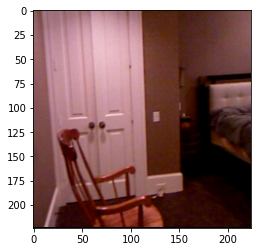

possible model answers:
photo
light_switch
decoration_item
mirror
mask
model answer: photo
real answer: light_switch


In [82]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

val_loader = torch.utils.data.DataLoader(DAQUAR(data=eval_data, transform=transform), batch_size=1, shuffle=True)
training_loader_iter = iter(val_loader)
img, question_embedding, question, answer = next(training_loader_iter)
for i in range(img.size(0)):
  print(question)
  imshow(img[i])
  model_ft.eval()
  FE = FeatureExtractor_resnet().to(device)
  img = FE(img.to(device))
  outputs = model_ft(img.to(device),question_embedding.to(device))
  _, preds = torch.max(outputs, 1)
  _, top_answers = torch.topk(outputs, 5)
  possible_answers=' '
  # print(len(top_answers[0]))
  print('possible model answers:')
  for x in top_answers[0]:
    print(label2answer[int(x)])
  # print(top_answers)
  # print(int(preds))
  # print(int(answer))
  print('model answer: '+label2answer[int(preds)])
  print('real answer: '+label2answer[int(answer)])

## nextt

In [ ]:
from torch.optim import lr_scheduler

optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

for i in range(100):
  net.train()
  # zero the parameter gradients
  optimizer.zero_grad()

  outputs = net(img.to(device),question_embedding.to(device))
  loss = criterion(outputs, answer)
  loss.backward()
  optimizer.step()
  print(loss.item())

6.354612350463867
6.249342441558838
5.960733413696289
5.044003963470459
3.4782419204711914
3.179637908935547
2.3183913230895996
2.4896180629730225
2.3067870140075684
2.4328248500823975
2.2946016788482666
2.1399786472320557
2.052137613296509
2.0021259784698486
1.9713449478149414
1.9231271743774414
1.8562250137329102
1.7687245607376099
1.666530966758728
1.5471755266189575
1.4098730087280273
1.266053318977356
1.1269710063934326
0.9674209952354431
0.8166856169700623


KeyboardInterrupt: ignored

In [ ]:
print(net)

In [ ]:
embedder = SentenceTransformer('all-mpnet-base-v2')
print(embedder)

In [ ]:
word_index = 1
answer_index = 0
answer_dic = {}
for response in answers:
  if len(response.split(','))>1:
    for i in range(len(response.split(','))):
      if i==0:
        answer_word = str(response.split(',')[i]).lower()
      else:
        answer_word = str(response.split(',')[i][1:]).lower()
      try:
        answer_dic[answer_word]+=1
      except:
        answer_dic[answer_word] = 1
  else:
    answer_word = str(response).lower()
    try:
        answer_dic[answer_word]+=1
    except:
        answer_dic[answer_word] = 1

In [ ]:
sorted_values = sorted(answer_dic.values()) # Sort the values
sorted_dict = {}

for i in sorted_values:
    for k in answer_dic.keys():
        if answer_dic[k] == i:
            sorted_dict[k] = answer_dic[k]

print(sorted_dict)

{'telephone_cord': 1, 'hand_sanitizer_dispenser': 1, 'electrical_outlet': 1, 'head_phone': 1, 'casserole_dish': 1, 'blender': 1, 'vegetable_peeler': 1, 'pitcher': 1, 'package_of_bottled_water': 1, 'onion': 1, 'crock_pot': 1, 'decorative_candle': 1, 'railing': 1, 'toy_truck': 1, 'ladel': 1, 'console_controller': 1, 'decorative_dish': 1, 'window_shelf': 1, 'range_hood': 1, 'dish_rack': 1, 'window_seat': 1, 'paper_towel': 1, 'wooden_planks': 1, 'box_of_paper': 1, 'staple_remover': 1, 'file_stand': 1, 'door_frame': 1, 'hockey_glove': 1, 'sign': 1, 'shopping_baskets': 1, '13': 1, 'coffee_packet': 1, 'cork_board': 1, '19': 1, 'ceiling': 1, 'canister': 1, 'lint_roller': 1, 'gift_wrapping_roll': 1, 'xbox': 1, 'stamp': 1, 'stick': 1, 'nailclipper': 1, 'drying_stand': 1, 'bucket': 1, 'iron_grill': 1, 'head_phones': 1, 'lint_comb': 1, 'pepper_shaker': 1, 'cooking_pot_cover': 1, 'ornamental_pot': 1, 'shaving_cream': 1, 'furniture': 1, 'cardboard_sheet': 1, 'hanging_hooks': 1, 'cat_cage': 1, 'plast

In [ ]:
sorted_dict

In [ ]:
sorted

In [ ]:
word_index = 1
answer_index = 0
answer_dic = {}
for response in answers:
  if len(response.split(','))>1:
    for i in range(len(response.split(','))):
      if i==0:
        answer_word = str(response.split(',')[i]).lower()
      else:
        answer_word = str(response.split(',')[i][1:]).lower()
      try:
        answer = answer_dic[answer_word]
      except:
        answer = answer_index
        answer_dic[answer_word] = answer_index
        answer_index += 1
  else:
    answer_word = str(response).lower()
    try:
        answer = answer_dic[answer_word]
    except:
        answer = answer_index
        answer_dic[answer_word] = answer_index
        answer_index += 1

In [ ]:
answer_dic

In [ ]:
import collections
od = collections.OrderedDict(sorted(answer_dic.items()))
od

OrderedDict([('1', 30),
             ('10', 135),
             ('11', 21),
             ('12', 311),
             ('13', 307),
             ('14', 270),
             ('15', 461),
             ('16', 354),
             ('18', 527),
             ('19', 326),
             ('2', 58),
             ('2163', 503),
             ('22', 428),
             ('3', 3),
             ('4', 89),
             ('5', 5),
             ('6', 47),
             ('7', 85),
             ('8', 25),
             ('9', 8),
             ('air_conditioner', 341),
             ('air_vent', 280),
             ('alarm', 409),
             ('alarm_clock', 340),
             ('album', 504),
             ('aluminium_foil', 94),
             ('apple', 526),
             ('ashtray', 105),
             ('baby_chair', 192),
             ('baby_gate', 485),
             ('back_scrubber', 510),
             ('backpack', 108),
             ('bag', 221),
             ('ball', 141),
             ('balloon', 494),
             ('ba

In [ ]:
a = 'fbwd, kbefk'
print(a.split(','))

['fbwd', ' kbefk']


In [ ]:
import json
path = '/content/drive/MyDrive/Vision/data_RAD/trainset.json'
with open(path) as f:
    train_data = json.load(f)

In [ ]:
embedder = SentenceTransformer('all-mpnet-base-v2')
result = []
word_index = 1
answer_index = 0
answer_dic = {}
for question in tqdm.tqdm(data):
    question_embedding = embedder.encode(question['question'], convert_to_tensor=True).to('cpu')
      # print(question['question'])
      # print(question_embedding.shape)
    answer_word = str(question['answer']).lower()
    try:
        answer = answer_dic[answer_word]

    except:
        answer = answer_index
        answer_dic[answer_word] = answer_index
        answer_index += 1

    result.append((question['image_name'], question_embedding, answer,
                  question['answer_type']))


In [ ]:
embedder = SentenceTransformer('all-mpnet-base-v2')
result = []
word_index = 1
answer_index = 0
answer_dic = {}
for question in tqdm.tqdm(data):
    question_embedding = embedder.encode(question['question'], convert_to_tensor=True).to('cpu')
      # print(question['question'])
      # print(question_embedding.shape)
    answer_word = str(question['answer']).lower()
    try:
        answer = answer_dic[answer_word]

    except:
        answer = answer_index
        answer_dic[answer_word] = answer_index
        answer_index += 1

    result.append((question['image_name'], question_embedding, answer,
                  question['answer_type']))


100%|██████████| 3064/3064 [00:35<00:00, 86.47it/s]


In [ ]:
print(len(result))

3064


In [ ]:
with open(f'train_data.pkl', 'wb') as f:
    pickle.dump(result, f)

In [ ]:
len(answer_dic)

476

## train data

In [ ]:
answer_dic

{'yes': 0,
 'no': 1,
 'ultrasound': 2,
 'the extremities': 3,
 'left temporal lobe': 4,
 'cardiovascular': 5,
 'vasculature': 6,
 'mri diffusion weighted': 7,
 'the brain': 8,
 'chest x-ray': 9,
 'axial': 10,
 'asymmetric': 11,
 'pulmonary nodules': 12,
 'free air': 13,
 'hypodense lesion': 14,
 'gi': 15,
 'ring-enhancing lesion': 16,
 'diffuse': 17,
 'ct': 18,
 'pancreas': 19,
 'right upper lobe': 20,
 'hypodense': 21,
 'left hepatic lobe': 22,
 'lungs': 23,
 'bilateral': 24,
 'cirrhosis': 25,
 'atherosclerotic calcification': 26,
 'right parietal lobe': 27,
 'chest': 28,
 'metastasis': 29,
 'enlarged': 30,
 'volume loss': 31,
 'one': 32,
 'extraluminal air and small fluid collection': 33,
 'nodular opacities': 34,
 'extra-axial and at the right choroidal fissure': 35,
 'prior surgery': 36,
 'ring-enhancing lesions': 37,
 'right temporal lobe': 38,
 'gallstones': 39,
 'right': 40,
 'abscess': 41,
 'cystic lesions': 42,
 'middle mogul': 43,
 'right lung': 44,
 'enlarged, fluid-filled':

In [ ]:
ans2label_path = '/content/drive/MyDrive/Vision/data_RAD/cache/trainval_ans2label.pkl'
ans2label = pickle.load(open(ans2label_path, 'rb'))

In [ ]:
ans2label

{'yes': 0,
 'no': 1,
 'ultrasound': 2,
 'extremities': 3,
 'left temporal lobe': 4,
 'cardiovascular': 5,
 'vasculature': 6,
 'mri diffusion weighted': 7,
 'brain': 8,
 'chest xray': 9,
 'axial': 10,
 'asymmetric': 11,
 'pulmonary nodules': 12,
 'free air': 13,
 'hypodense lesion': 14,
 'gi': 15,
 'ring enhancing lesion': 16,
 'diffuse': 17,
 'ct': 18,
 'pancreas': 19,
 'right upper lobe': 20,
 'hypodense': 21,
 'left hepatic lobe': 22,
 'lungs': 23,
 'bilateral': 24,
 'cirrhosis': 25,
 'atherosclerotic calcification': 26,
 'right parietal lobe': 27,
 'chest': 28,
 'metastasis': 29,
 'enlarged': 30,
 'volume loss': 31,
 '1': 32,
 'extraluminal air and small fluid collection': 33,
 'nodular opacities': 34,
 'extra axial and at right choroidal fissure': 35,
 'prior surgery': 36,
 'ring enhancing lesions': 37,
 'right temporal lobe': 38,
 'gallstones': 39,
 'right': 40,
 'abscess': 41,
 'cystic lesions': 42,
 'middle mogul': 43,
 'right lung': 44,
 'enlarged fluid filled': 45,
 'pancreati

In [ ]:
train_target_path = '/content/drive/MyDrive/Vision/data_RAD/cache/train_target.pkl'
train_target = pickle.load(open(train_target_path, 'rb'))

In [ ]:
len(train_target)

3064

In [ ]:
train_target[654]

{'qid': 767, 'image_name': 'synpic34017.jpg', 'labels': [1], 'scores': [1.0]}

In [ ]:
train_data[654]

{'qid': 767,
 'image_name': 'synpic34017.jpg',
 'image_organ': 'HEAD',
 'answer': 'No',
 'answer_type': 'CLOSED',
 'question_type': 'SIZE',
 'question': 'Are the basal ganglia enlarged?',
 'phrase_type': 'freeform'}

In [ ]:
data_closed = [train_data[i] for i in range(len(train_data)) if train_data[i]['answer_type']=='CLOSED']
train_target_closed = [train_target[i] for i in range(len(train_target)) if train_data[i]['answer_type']=='CLOSED']

In [ ]:
len(train_target_closed)

1821

In [ ]:
len(data_closed)

1821

In [ ]:
type(train_target_closed[456]['labels'])

list

In [ ]:
data_closed[456]

{'qid': 774,
 'image_name': 'synpic41788.jpg',
 'image_organ': 'HEAD',
 'answer': 'No',
 'answer_type': 'CLOSED',
 'question_type': 'PRES',
 'question': 'Is the lesion infiltrating?',
 'phrase_type': 'freeform'}

In [ ]:
label2ans_path = '/content/drive/MyDrive/Vision/data_RAD/cache/trainval_label2ans.pkl'
label2ans = pickle.load(open(label2ans_path, 'rb'))

In [ ]:
label2ans

['yes',
 'no',
 'ultrasound',
 'extremities',
 'left temporal lobe',
 'cardiovascular',
 'vasculature',
 'mri diffusion weighted',
 'brain',
 'chest xray',
 'axial',
 'asymmetric',
 'pulmonary nodules',
 'free air',
 'hypodense lesion',
 'gi',
 'ring enhancing lesion',
 'diffuse',
 'ct',
 'pancreas',
 'right upper lobe',
 'hypodense',
 'left hepatic lobe',
 'lungs',
 'bilateral',
 'cirrhosis',
 'atherosclerotic calcification',
 'right parietal lobe',
 'chest',
 'metastasis',
 'enlarged',
 'volume loss',
 '1',
 'extraluminal air and small fluid collection',
 'nodular opacities',
 'extra axial and at right choroidal fissure',
 'prior surgery',
 'ring enhancing lesions',
 'right temporal lobe',
 'gallstones',
 'right',
 'abscess',
 'cystic lesions',
 'middle mogul',
 'right lung',
 'enlarged fluid filled',
 'pancreatic body',
 'right lobe of liver',
 'right hemisphere',
 'right pca',
 'basal ganglia',
 'right superior cavoatrial junction',
 'ischemia',
 'suprasellar cistern',
 'above',
 '

In [ ]:
closed_answer_dic = {}
word_index = 1
answer_index = 0
for question in train_target_closed:
  label = question['labels'][0]
  answer_word = label2ans[label]
  try:
        answer = closed_answer_dic[answer_word]

  except:
        answer = answer_index
        closed_answer_dic[answer_word] = answer_index
        answer_index += 1

In [ ]:
closed_answer_dic

{'yes': 0,
 'no': 1,
 'asymmetric': 2,
 'diffuse': 3,
 'hypodense': 4,
 'enlarged': 5,
 'superior': 6,
 'left side': 7,
 'small bowel': 8,
 'left kidney': 9,
 'both': 10,
 'more dense': 11,
 'less dense': 12,
 'surrounding tissue': 13,
 'right side': 14,
 'just 1': 15,
 'solid': 16,
 'female': 17,
 'white matter': 18,
 'abscess': 19,
 'medical process': 20,
 'pa': 21,
 'contrast ct with gi and iv contrast': 22,
 'non contrast ct': 23,
 'with contrast': 24,
 'heterogeneous': 25,
 'right': 26,
 'bilateral frontal lobes': 27,
 'hyperintense': 28,
 'contrast': 29,
 'multilobulated': 30,
 'left': 31,
 'in vasculature': 32,
 'cystic': 33,
 'in bowels': 34,
 'radiolucent': 35,
 'ct': 36,
 'non enhanced': 37,
 'ap': 38,
 'flair': 39,
 'normal': 40,
 'base': 41,
 'non contrast': 42,
 'pleural effusion': 43,
 'genetic': 44,
 'vascular': 45,
 'not sure': 46,
 'maybe': 47,
 'gray matter': 48,
 'bilateral': 49,
 'both sides': 50,
 'exterior': 51,
 'outside': 52,
 'irregular': 53,
 'on top of patien

In [ ]:
for question in train_target_closed:
  label = question['labels'][0]
  answer_word = label2ans[label]
  question['closed_labels'] = closed_answer_dic[answer_word]

In [ ]:
closed_answer_dic

{'yes': 0,
 'no': 1,
 'asymmetric': 2,
 'diffuse': 3,
 'hypodense': 4,
 'enlarged': 5,
 'superior': 6,
 'left side': 7,
 'small bowel': 8,
 'left kidney': 9,
 'both': 10,
 'more dense': 11,
 'less dense': 12,
 'surrounding tissue': 13,
 'right side': 14,
 'just 1': 15,
 'solid': 16,
 'female': 17,
 'white matter': 18,
 'abscess': 19,
 'medical process': 20,
 'pa': 21,
 'contrast ct with gi and iv contrast': 22,
 'non contrast ct': 23,
 'with contrast': 24,
 'heterogeneous': 25,
 'right': 26,
 'bilateral frontal lobes': 27,
 'hyperintense': 28,
 'contrast': 29,
 'multilobulated': 30,
 'left': 31,
 'in vasculature': 32,
 'cystic': 33,
 'in bowels': 34,
 'radiolucent': 35,
 'ct': 36,
 'non enhanced': 37,
 'ap': 38,
 'flair': 39,
 'normal': 40,
 'base': 41,
 'non contrast': 42,
 'pleural effusion': 43,
 'genetic': 44,
 'vascular': 45,
 'not sure': 46,
 'maybe': 47,
 'gray matter': 48,
 'bilateral': 49,
 'both sides': 50,
 'exterior': 51,
 'outside': 52,
 'irregular': 53,
 'on top of patien

In [ ]:
train_target_closed[89]

{'qid': 116,
 'image_name': 'synpic16174.jpg',
 'labels': [0],
 'scores': [1.0],
 'closed_labels': 0}

In [ ]:
with open(f'trainval_closed_ans2label.pkl', 'wb') as f:
    pickle.dump(closed_answer_dic, f)

## text data

In [ ]:
import json
path = '/content/drive/MyDrive/Vision/data_RAD/testset.json'
with open(path) as f:
    test_data = json.load(f)

In [ ]:
test_target_path = '/content/drive/MyDrive/Vision/data_RAD/cache/test_target.pkl'
test_target = pickle.load(open(test_target_path, 'rb'))

In [ ]:
print(len(test_target))
print(len(test_data))

451
451


In [ ]:
test_data

[{'qid': 11,
  'image_name': 'synpic42202.jpg',
  'image_organ': 'CHEST',
  'answer': 'yes',
  'answer_type': 'CLOSED',
  'question_type': 'PRES',
  'question': 'Is there evidence of an aortic aneurysm?',
  'phrase_type': 'freeform'},
 {'qid': 13,
  'image_name': 'synpic29265.jpg',
  'image_organ': 'CHEST',
  'answer': 'Yes',
  'answer_type': 'CLOSED',
  'question_type': 'PRES',
  'question': 'Is there airspace consolidation on the left side?',
  'phrase_type': 'freeform'},
 {'qid': 14,
  'image_name': 'synpic54610.jpg',
  'image_organ': 'HEAD',
  'answer': 'yes',
  'answer_type': 'CLOSED',
  'question_type': 'PLANE',
  'question': 'Is this an axial plane?',
  'phrase_type': 'freeform'},
 {'qid': 20,
  'image_name': 'synpic29265.jpg',
  'image_organ': 'CHEST',
  'answer': 'Posterior-Anterior',
  'answer_type': 'OPEN',
  'question_type': 'OTHER',
  'question': 'How is the patient oriented?',
  'phrase_type': 'freeform'},
 {'qid': 22,
  'image_name': 'synpic54610.jpg',
  'image_organ': '

In [ ]:
test_data_closed = [test_data[i] for i in range(len(test_data)) if test_data[i]['answer_type']=='CLOSED']
test_target_closed = [test_target[i] for i in range(len(test_target)) if test_data[i]['answer_type']=='CLOSED']

In [ ]:
len(test_target_closed)

272

In [ ]:
test_target_closed

[{'qid': 11, 'image_name': 'synpic42202.jpg', 'labels': [0], 'scores': [1.0]},
 {'qid': 13, 'image_name': 'synpic29265.jpg', 'labels': [0], 'scores': [1.0]},
 {'qid': 14, 'image_name': 'synpic54610.jpg', 'labels': [0], 'scores': [1.0]},
 {'qid': 22, 'image_name': 'synpic54610.jpg', 'labels': [0], 'scores': [1.0]},
 {'qid': 24, 'image_name': 'synpic42202.jpg', 'labels': [0], 'scores': [1.0]},
 {'qid': 32, 'image_name': 'synpic21776.jpg', 'labels': [0], 'scores': [1.0]},
 {'qid': 34, 'image_name': 'synpic21776.jpg', 'labels': [0], 'scores': [1.0]},
 {'qid': 36, 'image_name': 'synpic25821.jpg', 'labels': [1], 'scores': [1.0]},
 {'qid': 38, 'image_name': 'synpic25821.jpg', 'labels': [1], 'scores': [1.0]},
 {'qid': 40, 'image_name': 'synpic25821.jpg', 'labels': [1], 'scores': [1.0]},
 {'qid': 42, 'image_name': 'synpic25821.jpg', 'labels': [1], 'scores': [1.0]},
 {'qid': 46, 'image_name': 'synpic34515.jpg', 'labels': [0], 'scores': [1.0]},
 {'qid': 47, 'image_name': 'synpic34515.jpg', 'label

In [ ]:
closed_answer_dic = {}
word_index = 1
answer_index = 0
for question in test_target_closed:
  if question['labels']!=[]:
    label = question['labels'][0]
    answer_word = label2ans[label]
    try:
          answer = closed_answer_dic[answer_word]

    except:
          answer = answer_index
          closed_answer_dic[answer_word] = answer_index
          answer_index += 1

In [ ]:
test_data_closed

[{'qid': 11,
  'image_name': 'synpic42202.jpg',
  'image_organ': 'CHEST',
  'answer': 'yes',
  'answer_type': 'CLOSED',
  'question_type': 'PRES',
  'question': 'Is there evidence of an aortic aneurysm?',
  'phrase_type': 'freeform'},
 {'qid': 13,
  'image_name': 'synpic29265.jpg',
  'image_organ': 'CHEST',
  'answer': 'Yes',
  'answer_type': 'CLOSED',
  'question_type': 'PRES',
  'question': 'Is there airspace consolidation on the left side?',
  'phrase_type': 'freeform'},
 {'qid': 14,
  'image_name': 'synpic54610.jpg',
  'image_organ': 'HEAD',
  'answer': 'yes',
  'answer_type': 'CLOSED',
  'question_type': 'PLANE',
  'question': 'Is this an axial plane?',
  'phrase_type': 'freeform'},
 {'qid': 22,
  'image_name': 'synpic54610.jpg',
  'image_organ': 'HEAD',
  'answer': 'yes',
  'answer_type': 'CLOSED',
  'question_type': 'ABN',
  'question': 'Is there vascular pathology in this image?',
  'phrase_type': 'freeform'},
 {'qid': 24,
  'image_name': 'synpic42202.jpg',
  'image_organ': 'CH

In [ ]:
closed_answer_dic

{'yes': 0,
 'no': 1,
 '1': 2,
 'left': 3,
 'mri': 4,
 'female': 5,
 'right': 6,
 'cystic': 7,
 'right side': 8,
 'both': 9,
 'bilateral': 10,
 'axial': 11,
 'flair': 12}

In [ ]:
answers = []
for q in test_data_closed:
  answers.append(q['answer'].lower())
set(answers)

{'abnormal',
 'axial',
 'bilateral',
 'both',
 'cystic',
 'female',
 'flair',
 'hyperinflation',
 'left',
 'mri',
 'no',
 'one',
 'right',
 'right side',
 'smaller',
 'supratentorial',
 'yes'}